In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whic

In [3]:
from datasets import load_dataset

# Analyzing the content of the columns

In [4]:
ds = load_dataset("Elfsong/Venus", "python3")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2481 [00:00<?, ? examples/s]

In [5]:
ds['train'].features

{'question_id': Value(dtype='int64', id=None),
 'name': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'acRate': Value(dtype='float64', id=None),
 'difficulty': Value(dtype='string', id=None),
 'topics': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'runtimeDistribution': Value(dtype='string', id=None),
 'memoryDistribution': Value(dtype='string', id=None),
 'rt_list': [{'code': Value(dtype='string', id=None),
   'runtime': Value(dtype='string', id=None)}],
 'rt_solution_count': Value(dtype='int64', id=None),
 'mm_list': [{'code': Value(dtype='string', id=None),
   'memory': Value(dtype='string', id=None)}],
 'mm_solution_count': Value(dtype='int64', id=None),
 'code_prompt': Value(dtype='string', id=None)}

In [6]:
rt_dist = ds['train'][0]['runtimeDistribution']

In [7]:
import json

In [8]:
rt_dist = json.loads(rt_dist)

In [9]:
import matplotlib.pyplot as plt


In [10]:
def plot_distribution(data, name=None, instance=None):
    x = [int(item[0]) for item in data]
    y = [item[1] for item in data]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label="Distribution")

    # If an instance tuple is provided, plot it with a different color
    if instance is not None:
        # Assuming the instance tuple is (runtime, frequency)
        instance_runtime = (instance[0])
        instance_freq = instance[1]
        plt.plot(instance_runtime, instance_freq, marker='o', markersize=10,
                 linestyle='None', color='r', label="Instance")

    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.title(f"{name} Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

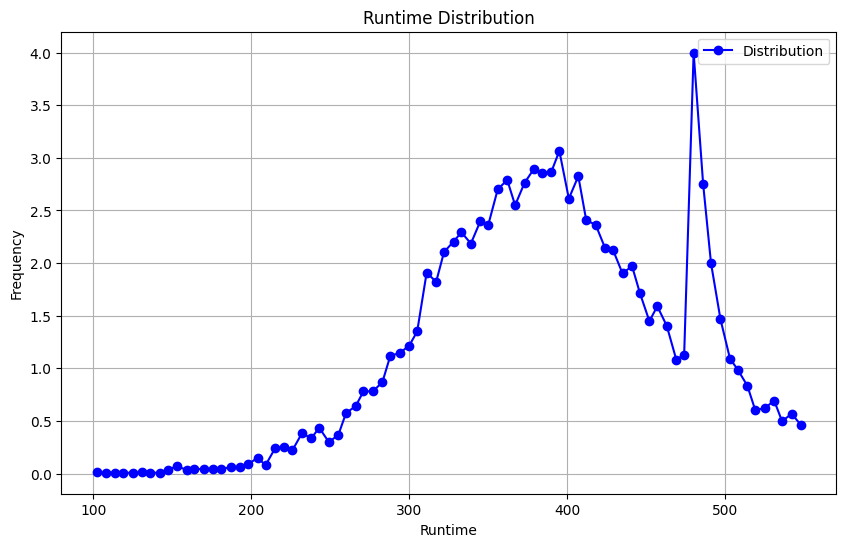

In [11]:
plot_distribution(rt_dist['distribution'], name='Runtime')

In [12]:
import pandas as pd

In [13]:

def to_pandas_df(data, name):
    dist_df = pd.DataFrame(data, columns=[name, 'frequency'])

    # Convert the 'Runtime' column from string to integer
    dist_df[name] = dist_df[name].astype(int)

    # Sort the DataFrame by runtime
    dist_df.sort_values(name, inplace=True)

    # Compute the cumulative sum of frequencies
    # dist_df['Cumulative'] = dist_df['frequency'].cumsum()

    return dist_df

In [14]:
dist_df = to_pandas_df(rt_dist['distribution'], 'runtime')

In [15]:
# Picking a random sample to see where it fit on the distribution
row = dist_df.sample(n=1)
row

,runtime,frequency
61,446,1.7149


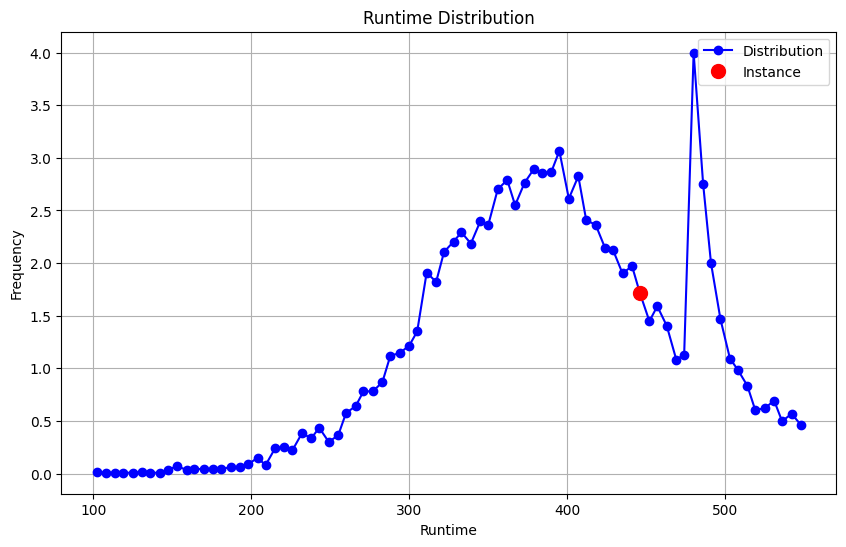

In [16]:
point = (int(row['runtime'].iloc[0]), row['frequency'])
plot_distribution(rt_dist['distribution'], 'Runtime', point)

In [17]:
import numpy as np

In [18]:
# get the nth percentile value of the distribution
def get_nth_percentile(distribution_df, percentile, metric):
    data = np.array(distribution_df[metric])
    return np.percentile(data, percentile)

# check if an instance of the distribution falls into the nth percentile
def is_within_nth_percentile(nth_percentile, instance):
    return instance <= nth_percentile

In [19]:
get_nth_percentile(dist_df, 25, 'runtime')

213.5

# Constructing the dataset

In [20]:
json_dataset = []

# Iterate over the 'train' split
for row in ds["train"]:
    new_row = {}
    prompt = row['content']
    runtime_efficient_codes = []
    runtime_inefficient_codes = []
    memory_efficient_codes = []
    memory_inefficient_codes = []

    # Get both runtime and memory distribution for the current problem
    runtime_distribution = to_pandas_df(json.loads(row['runtimeDistribution'])['distribution'], 'runtime')
    memory_distribution = to_pandas_df(json.loads(row['memoryDistribution'])['distribution'], 'memory')

    # Obtain the 25th percentile for both runtime and memory distribution
    runtime_percentile = get_nth_percentile(runtime_distribution, 25, 'runtime')
    memory_percentile = get_nth_percentile(memory_distribution, 25, 'memory')

    # For each solution to current problem
    #   check if solution runtime falls within the 25th precentile
    #       if yes then the code is considered effcient
    #       otherwise the code is considered inefficent
    #   Note: The data does not define which code is efficient or not, or
    #   optimize. Therefore, we have to establish some classifier to determine
    #   which code is effecient or not. Hence, the reason why I decided to look
    #   athe 25th percentile
    for rt_item in row['rt_list']:
        # runtime of the current solution
        runtime = int(rt_item['runtime'])

        # check is code is effcient or not based on runtime and 25th percentile
        if is_within_nth_percentile(runtime_percentile, runtime):
            runtime_efficient_codes.append(rt_item)
        else:
            runtime_inefficient_codes.append(rt_item)

    # Applying the same concept as the above, but for memory efficent code
    for mm_item in row['mm_list']:
        memory = int(mm_item['memory'])

        if is_within_nth_percentile(memory_percentile, memory):
            memory_efficient_codes.append(mm_item)
        else:
            memory_inefficient_codes.append(mm_item)

    json_data = {
        'promt': prompt,
        'runtime_inefficient_codes': runtime_inefficient_codes,
        'runtime_efficient_codes': runtime_efficient_codes,
        'memory_inefficient_codes': memory_inefficient_codes,
        'memory_efficient_codes': memory_efficient_codes
    }

    json_dataset.append(json_data)


In [24]:
with open('code_data.json', 'w') as json_file:
    json.dump(json_dataset, json_file, indent=4)

In [23]:
pd.DataFrame(json_dataset)

,promt,runtime_inefficient_codes,runtime_efficient_codes,memory_inefficient_codes,memory_efficient_codes
0,"<p>Given a string <code>s</code>, partition <c...",[{'code': 'class Solution: def partition(s...,[{'code': '# class Solution: def partition( s:...,[{'code': 'class Solution: def partition(s...,[{'code': 'from collections.abc import Generat...
1,"<p>Given a string <code>s</code>, partition <c...",[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...
2,<p>Given a reference of a node in a <strong><a...,"[{'code': '"""""" # Definition for a Node. class ...",[{'code': 'class Solution: def cloneGraph(...,"[{'code': '"""""" # Definition for a Node. class ...","[{'code': '"""""" # Definition for a Node. class ..."
3,<p>There are <code>n</code> gas stations along...,[{'code': 'class Solution: def canComplete...,[{'code': 'def canCompleteCircuit(gas: List[in...,[{'code': 'class Solution: def canComplete...,[{'code': 'class Solution: def canComplete...
4,<p>There are <code>n</code> children standing ...,"[{'code': 'class Solution: def candy(self,...",[{'code': 'class Solution: def candy(self...,"[{'code': 'class Solution: def candy(self,...","[{'code': 'class Solution: def candy(self,..."
...,...,...,...,...,...
2476,<p>You are given an integer array <code>enemyE...,[{'code': 'class Solution: def maximumPoin...,[{'code': 'class Solution: def maximumPoin...,[{'code': 'class Solution: def maximumPoin...,[{'code': 'class Solution: def maximumPoin...
2477,<p>There is a circle of red and blue tiles. Yo...,[{'code': 'class Solution: def numberOfAlt...,[{'code': 'class Solution: def numberOfAlt...,[{'code': 'class Solution: def numberOfAlt...,[{'code': 'class Solution: def numberOfAlt...
2478,"<p>For a stream of integers, implement a data ...",[{'code': 'class DataStream: def __init__(...,[{'code': 'class DataStream: def __init__(...,[{'code': 'class DataStream: def __init__...,[{'code': 'class DataStream: def __init__(...
2479,<p>You are given a <strong>0-indexed</strong> ...,[{'code': 'class Solution: def maxPower(se...,[{'code': 'class Solution: def maxPower(se...,[{'code': 'class Solution: def maxPower(se...,"[{'code': 'def is_ok(val, stations, r, k): ..."


No charts were generated by quickchart
